In [1]:
!find ./resultados_13_paper_qc_beta3/ -name "shap_pack_mlp.joblib" -print -delete

In [2]:
# RUTAS
RUN="/home/diego/Escritorio/limpio/resultados_13_paper_qc_beta3"
GT="/home/diego/Escritorio/limpio/AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz"
META="/home/diego/Escritorio/limpio/SubjectsData_AAL3_procesado2.csv"
ANNO="/home/diego/Escritorio/limpio/roi_info_master.csv"

# 1) SHAP (congelado)
for f in [1, 2, 3, 4, 5]:
    !python interpretar_fold_paper_mean.py shap \
    --run_dir "$RUN" \
    --fold $f \
    --clf mlp \
    --global_tensor_path "$GT" \
    --metadata_path "$META" \
    --channels_to_use 1 2 5 \
    --latent_dim 256 \
    --latent_features_type mu \
    --metadata_features Age Sex \
    --num_conv_layers_encoder 4 \
    --decoder_type convtranspose \
    --dropout_rate_vae 0.2 \
    --intermediate_fc_dim_vae quarter \
    --vae_final_activation tanh \
    --kernel_nsamples 5000 \
    --shap_link logit \
    --bg_mode train --bg_sample_size 100 --bg_seed 42 \
    --freeze_meta Age Sex --freeze_strategy train_stats \
    --shap_normalize by_logit_median \
    --shap_tag frozen

# 2) SALIENCY (usa el pack 'frozen')
for f in [1, 2, 3, 4, 5]:
    !python interpretar_fold_paper_mean.py saliency \
    --run_dir "$RUN" \
    --fold $f \
    --clf mlp \
    --global_tensor_path "$GT" \
    --metadata_path "$META" \
    --channels_to_use 1 2 5 \
    --latent_dim 256 \
    --latent_features_type mu \
    --metadata_features Age Sex \
    --num_conv_layers_encoder 4 \
    --decoder_type convtranspose \
    --dropout_rate_vae 0.2 \
    --intermediate_fc_dim_vae quarter \
    --vae_final_activation tanh \
    --roi_annotation_path "$ANNO" \
    --top_k 50 \
    --shap_weight_mode ad_vs_cn_diff \
    --saliency_method integrated_gradients \
    --ig_n_steps 64 \
    --ig_baseline cn_median_train \
    --shap_tag frozen


[INFO] [SHAP] fold=1 clf=mlp
[WARNING] label_mapping.json no encontrado; se asume CN=0 / AD=1
[INFO] [SHAP] META congelado para ['Age', 'Sex'] (train_stats).
[INFO] [SHAP] X_raw (test) shape=(37, 258) (latentes + 2 metadatos)
[INFO] [SHAP] Latentes detectadas en procesado: 256 / 258
[INFO] [SHAP] No hay background RAW. Construyendo con bg_mode=train…
[INFO] [SHAP] Background RAW → shap_background_raw_mlp_train_frozen.joblib; PROCESADO → shap_background_proc_mlp_train_frozen.joblib
[dtype('float32') dtype('float64') dtype('O')]
[dtype('float64')]
[INFO] [SHAP] Usando shap.Explainer + Independent masker (permutation/interventional).
[INFO] [SHAP] Permutation: F=258, min_required=517, usando max_evals=5000.
PermutationExplainer explainer: 38it [00:57,  1.69s/it]                         
[INFO] [SHAP] SHAP forzados a 0 por ser constantes: ['Age']
[INFO] [SHAP] Normalizado por mediana |f(x)-base| (escala ~logit): factor=3.103
[INFO] [SHAP] Pack guardado: /home/diego/Escritorio/limpio/result

In [3]:
for f in [1, 2, 3, 4, 5]:
  !python interpretar_fold_paper_mean.py shap \
    --run_dir "$RUN" \
    --fold $f \
    --clf mlp \
    --global_tensor_path "$GT" \
    --metadata_path "$META" \
    --channels_to_use 1 2 5 \
    --latent_dim 256 \
    --latent_features_type mu \
    --metadata_features Age Sex \
    --num_conv_layers_encoder 4 \
    --decoder_type convtranspose \
    --dropout_rate_vae 0.2 \
    --intermediate_fc_dim_vae quarter \
    --vae_final_activation tanh \
    --kernel_nsamples 5000 \
    --shap_link logit \
    --bg_mode train --bg_sample_size 100 --bg_seed 42 \
    --shap_normalize by_logit_median \
    --shap_tag unfrozen

[INFO] [SHAP] fold=1 clf=mlp
[WARNING] label_mapping.json no encontrado; se asume CN=0 / AD=1
[INFO] [SHAP] X_raw (test) shape=(37, 258) (latentes + 2 metadatos)
[INFO] [SHAP] Latentes detectadas en procesado: 256 / 258
[INFO] [SHAP] Cargando background PROCESADO (cache): shap_background_proc_mlp_train_unfrozen.joblib
[dtype('float64')]
[dtype('float64')]
[INFO] [SHAP] Usando shap.Explainer + Independent masker (permutation/interventional).
[INFO] [SHAP] Permutation: F=258, min_required=517, usando max_evals=5000.
PermutationExplainer explainer: 38it [00:57,  1.68s/it]                         
[INFO] [SHAP] Normalizado por mediana |f(x)-base| (escala ~logit): factor=2.871
[INFO] [SHAP] Pack guardado: /home/diego/Escritorio/limpio/resultados_13_paper_qc_beta3/fold_1/interpretability_shap/shap_pack_mlp_unfrozen.joblib
[INFO] [SHAP] fold=2 clf=mlp
[WARNING] label_mapping.json no encontrado; se asume CN=0 / AD=1
[INFO] [SHAP] X_raw (test) shape=(37, 258) (latentes + 2 metadatos)
[INFO] [SH

In [68]:
# compare_freeze.py
from pathlib import Path
import joblib, numpy as np, pandas as pd, sys

run, clf = "/home/diego/Escritorio/limpio/resultados_13_paper_qc_beta3", "mlp"
rows=[]
for f in range(1,6):
    d = Path(run)/f"fold_{f}"/"interpretability_shap"
    pf = joblib.load(d/f"shap_pack_{clf}_frozen.joblib")
    pu = joblib.load(d/f"shap_pack_{clf}_unfrozen.joblib")
    mask = np.array(pf['latent_feature_mask'], bool)
    # media por feature (|SHAP|) en test
    mf = np.abs(pf['shap_values']).mean(axis=0)[mask]
    mu = np.abs(pu['shap_values']).mean(axis=0)[mask]
    r = np.corrcoef(mf, mu)[0,1]
    rows.append({'fold':f, 'pearson_absSHAP_latents_frozen_vs_unfrozen': float(r)})
pd.DataFrame(rows).to_csv(Path(run)/f"compare_{clf}_frozen_unfrozen.csv", index=False)
print(pd.DataFrame(rows))


   fold  pearson_absSHAP_latents_frozen_vs_unfrozen
0     1                                    0.999697
1     2                                    0.999521
2     3                                    0.999485
3     4                                    0.999435
4     5                                    0.999631


In [69]:
# utils_loader.py  (o pegalo al comienzo de tu notebook/script)
from pathlib import Path
import joblib, re

def find_shap_pack(run_dir: Path, fold: int, clf: str,
                   prefer_order=("fixed", "frozen", "unfrozen", "")) -> Path:
    """
    Devuelve la ruta al shap_pack del fold/clf, priorizando:
    fixed > frozen > unfrozen > (sin sufijo).
    """
    base = run_dir / f"fold_{fold}" / "interpretability_shap"
    cand = {
        "fixed":     base / f"shap_pack_{clf}_fixed.joblib",
        "frozen":    base / f"shap_pack_{clf}_frozen.joblib",
        "unfrozen":  base / f"shap_pack_{clf}_unfrozen.joblib",
        "":          base / f"shap_pack_{clf}.joblib",
    }
    for key in prefer_order:
        p = cand[key]
        if p.exists():
            return p
    # Fallback: cualquier shap_pack_<clf>_*.joblib
    globs = sorted(base.glob(f"shap_pack_{clf}_*.joblib"))
    if globs:
        return globs[0]
    raise FileNotFoundError(f"No encontré shap_pack para {clf} en {base}")

def load_shap_pack(run_dir: Path, fold: int, clf: str):
    p = find_shap_pack(run_dir, fold, clf)
    pack = joblib.load(p)
    pack["_pack_path"] = p  # útil para inferir sufijos luego
    return pack


In [70]:
# ==== SETUP RUTAS ====
from pathlib import Path
import joblib, numpy as np, pandas as pd, re

RUN_DIR = Path("/home/diego/Escritorio/limpio/resultados_13_paper_qc_beta3")
GT      = Path("/home/diego/Escritorio/limpio/AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz")
META    = Path("/home/diego/Escritorio/limpio/SubjectsData_AAL3_procesado2.csv")
ANNO    = Path("/home/diego/Escritorio/limpio/roi_info_master.csv")
CLF     = "mlp"
EPS     = 1e-12  # tolerancia p/constancia numérica

def _load_pack(run_dir, fold, clf, prefer=("","_frozen","_unfrozen")):
    """Carga shap_pack_<clf>[sufijo].joblib priorizando el orden en 'prefer'."""
    base = run_dir/f"fold_{fold}/interpretability_shap"
    last_err = None
    for suf in prefer:
        p = base/f"shap_pack_{clf}{suf}.joblib"
        try:
            pack = joblib.load(p)
            pack["_pack_path"] = p
            return pack
        except Exception as e:
            last_err = e
    raise last_err

def _const_mask(df_or_np, cols_idx=None, eps=EPS):
    """Varianza ~0 -> constante. Acepta DataFrame o ndarray."""
    import numpy as _np
    X = df_or_np.to_numpy(copy=False) if hasattr(df_or_np, "to_numpy") else _np.asarray(df_or_np)
    if cols_idx is not None:
        X = X[:, cols_idx]
    stds = _np.nanstd(_np.asarray(X, float), axis=0)
    return stds < eps

def hotfix_zero_out_constants(pack, run_dir, fold, clf, eps=EPS, save_suffix="_fixed"):
    """
    Si Age/Sex (u otra feature) está CONGELADA (varianza≈0) tanto en X_test como en BG,
    fuerza sus SHAP a 0 y guarda shap_pack_<clf>_fixed.joblib. Devuelve ruta guardada.
    """
    S = np.asarray(pack["shap_values"], float)
    X = pack["X_test"]
    names = list(map(str, pack["feature_names"]))

    # Cargar el background procesado que corresponde a global_cn
    bg = joblib.load(run_dir/f"fold_{fold}/shap_background_proc_{clf}_global_cn.joblib")

    const_in_X  = _const_mask(X, eps=eps)
    const_in_BG = _const_mask(bg[names], eps=eps) if set(names).issubset(set(bg.columns)) else _const_mask(bg, eps=eps)
    const_both  = const_in_X & const_in_BG

    const_feats = [names[i] for i, c in enumerate(const_both) if c]
    if const_feats:
        S[:, const_both] = 0.0
        pack["shap_values"] = S
        pack["constant_features_zeroed"] = const_feats
        out = pack["_pack_path"].with_name(f"shap_pack_{clf}{save_suffix}.joblib")
        joblib.dump(pack, out)
        print(f"🔧 Hotfix aplicado → cero en {len(const_feats)} features constantes:", const_feats, "\nGuardado:", out)
        return out
    else:
        print("✅ No hay features verdaderamente constantes (X_test & BG). No se aplica hotfix.")
        return None


In [71]:
import numpy as np

for FOLD in [1,2,3,4,5]:
    pack = _load_pack(RUN_DIR, FOLD, CLF, prefer=("_frozen",))
    S = np.asarray(pack["shap_values"], float)
    X = pack["X_test"]; names = list(map(str, pack["feature_names"]))

    # Ubico Age y Sex
    idx_age = [i for i,n in enumerate(names) if re.search(r'(?:^|__)Age\b', n)]
    idx_sex = [i for i,n in enumerate(names) if re.search(r'(?:^|__)Sex\b', n)]

    # Varianzas
    std_age_X = float(X.iloc[:, idx_age].std(numeric_only=True).mean()) if idx_age else np.nan
    try:
        bg = joblib.load(RUN_DIR/f"fold_{FOLD}/shap_background_proc_{CLF}_global_cn.joblib")
        std_age_BG = float(bg[names].iloc[:, idx_age].std(numeric_only=True).mean()) if idx_age else np.nan
    except Exception:
        std_age_BG = np.nan

    mean_abs_age = float(np.abs(S[:, idx_age]).mean()) if idx_age else np.nan

    print(f"Fold {FOLD}: std(Age) X={std_age_X:.2e}, BG={std_age_BG:.2e}, mean|SHAP|(Age)={mean_abs_age:.3f}")

    # Si Age/ Sex es ~constante en X y BG pero SHAP no ~0 => aplico hotfix
    if (idx_age and std_age_X < EPS and (np.isnan(std_age_BG) or std_age_BG < EPS) and mean_abs_age > 1e-6):
        hotfix_zero_out_constants(pack, RUN_DIR, FOLD, CLF, eps=EPS, save_suffix="_fixed")


Fold 1: std(Age) X=7.03e-18, BG=1.43e-14, mean|SHAP|(Age)=0.000
Fold 2: std(Age) X=3.52e-18, BG=1.43e-14, mean|SHAP|(Age)=0.000
Fold 3: std(Age) X=1.76e-18, BG=2.86e-14, mean|SHAP|(Age)=0.000
Fold 4: std(Age) X=1.76e-18, BG=1.43e-14, mean|SHAP|(Age)=0.000
Fold 5: std(Age) X=2.20e-19, BG=1.43e-14, mean|SHAP|(Age)=0.000


In [72]:
import numpy as np, matplotlib.pyplot as plt, shap, re

EPS = 1e-12  # ya lo usas; mantén coherente

def summary_plot_single_safe(S_col, X_col, name, title, out_png, out_svg, out_pdf=None, prefer_violin=True, eps=EPS):
    """
    S_col: array shape (N,) o (N,1) con SHAP de UNA feature.
    X_col: DataFrame/Series con esa feature (mismo N).
    Si var(S_col) ~ 0 -> evitamos KDE y hacemos un fallback seguro.
    """
    s = np.asarray(S_col, float).reshape(-1)
    if np.isnan(s).all() or np.nanstd(s) < eps:
        # Fallback seguro (sin KDE)
        plt.figure(figsize=(6, 2.8))
        plt.axvline(0, color="black", linestyle="--", linewidth=1)
        # “rug” de puntos en y=0 con leve jitter vertical para visibilidad
        y = 0.03 * np.random.randn(len(s))
        plt.scatter(s, y, s=14, edgecolors="white", linewidths=0.4)
        plt.title(f"{title} (constante · SHAP≈0)")
        plt.tight_layout()
        plt.savefig(out_png, dpi=150); plt.savefig(out_svg)
        if out_pdf: plt.savefig(out_pdf)
        plt.close()
        return

        # Si NO es degenerado, podemos usar summary_plot normalmente
    plt.figure(figsize=(6, 2.8))
    shap.summary_plot(s[:, None], X_col.to_frame(), feature_names=[name],
                      plot_type=("violin" if prefer_violin else "dot"),
                      show=False, max_display=1)
    plt.axvline(0, color="black", linestyle="--", linewidth=1)
    plt.title(title); plt.tight_layout()
    plt.savefig(out_png, dpi=150); plt.savefig(out_svg)
    plt.show()
    if out_pdf: plt.savefig(out_pdf)
    plt.close()

def filter_nondegenerate_columns(S_block, X_block, names, eps=EPS):
    """Elimina columnas con std(S) ~ 0 para evitar KDE singular."""
    stds = np.nanstd(np.asarray(S_block, float), axis=0)
    keep = stds > eps
    return S_block[:, keep], X_block.iloc[:, list(np.where(keep)[0])], np.array(names)[keep], keep


In [73]:
# === (1) Ranking por fold y promedio global (latentes + metadatos) ===
import numpy as np, pandas as pd
all_ranks=[]
for FOLD in [1,2,3,4,5]:
    base = RUN_DIR/f"fold_{FOLD}/interpretability_shap"
    # Lógica corregida (para Celda 19 y 38):
    pack = joblib.load(
        (base/f"shap_pack_{CLF}_fixed.joblib")
        if (base/f"shap_pack_{CLF}_fixed.joblib").exists() 
        # 👇 CAMBIO AQUÍ: usa el pack 'frozen' como fallback
        else (base/f"shap_pack_{CLF}_frozen.joblib") 
    )
    S = np.asarray(pack["shap_values"], float)
    names = list(map(str, pack["feature_names"]))
    mean_abs = np.abs(S).mean(axis=0)
    df = (pd.DataFrame({"feature":names, "mean_abs_shap":mean_abs})
            .assign(pretty_feature=lambda d: d["feature"].map(_prettify))
            .sort_values("mean_abs_shap", ascending=False))
    df["fold"]=FOLD
    df.to_csv(base/f"fold{FOLD}_shap_feature_importance_ranking.csv", index=False)
    all_ranks.append(df)

df_all = pd.concat(all_ranks, ignore_index=True)
df_global = (df_all.groupby(["feature","pretty_feature"], as_index=False)
                 .agg(mean_abs_shap_across_folds=("mean_abs_shap","mean"),
                      std_abs_shap_across_folds=("mean_abs_shap","std"),
                      n_folds=("fold","nunique"))
                 .sort_values("mean_abs_shap_across_folds", ascending=False))
df_global.to_csv(RUN_DIR/"shap_feature_importance_across_folds.csv", index=False)
print("✅ Guardado: shap_feature_importance_across_folds.csv")

# === (2) Consenso de conexiones (a partir de SALIENCY IG top-50 anotado por fold) ===
from pathlib import Path
RUN = RUN_DIR; clf = "mlp"; tag = "integrated_gradients_top50"
files=[RUN/f"fold_{i}"/f"interpretability_{clf}"/f"ranking_conexiones_ANOTADO_{tag}.csv" for i in range(1,6)]
dfs=[pd.read_csv(f) for f in files]

def _edge_key(df):
    a=df['src_AAL3_Name'].astype(str); b=df['dst_AAL3_Name'].astype(str)
    return pd.DataFrame({'a':a,'b':b}).apply(lambda r: tuple(sorted([r['a'], r['b']])), axis=1)

tops=[set(df.head(200).assign(K=_edge_key(df)).K) for df in dfs]
jacc=[]
for i in range(5):
    for j in range(i+1,5):
        inter=len(tops[i]&tops[j]); union=len(tops[i]|tops[j]); jacc.append(inter/union if union else 0)
print(f"Mean Jaccard top-200: {np.mean(jacc):.3f}")

all_df=pd.concat([df.assign(K=_edge_key(df)) for df in dfs], ignore_index=True)
gb=(all_df.groupby('K', as_index=False)
        .agg(freq=('K','size'),
             Saliency_Abs_mean=('Saliency_Abs','mean'),
             Saliency_Signed_mean=('Saliency_Signed','mean')))
gb=gb.sort_values(['freq','Saliency_Abs_mean'], ascending=[False,False])
gb.to_csv(RUN/f"consensus_edges_{clf}_{tag}.csv", index=False)
print("✅ Guardado:", RUN/f"consensus_edges_{clf}_{tag}.csv")

# === (3) Aporte por canal (consolida channel_contributions_* por fold) ===
rows=[]
for f in range(1,6):
    p=RUN/f"fold_{f}"/f"interpretability_{clf}"/f"channel_contributions_{tag}.csv"
    rows.append(pd.read_csv(p).assign(fold=f))
df=pd.concat(rows)
g=(df.groupby(['channel_index_used','channel_name'], as_index=False)
     .agg(frac_mean=('l1_norm_fraction_abs','mean'),
          frac_std=('l1_norm_fraction_abs','std')))
g.to_csv(RUN/f"channels_consensus_{clf}_{tag}.csv", index=False)
print("✅ Guardado:", RUN/f"channels_consensus_{clf}_{tag}.csv")
display(g.sort_values('frac_mean', ascending=False))


✅ Guardado: shap_feature_importance_across_folds.csv
Mean Jaccard top-200: 0.042
✅ Guardado: /home/diego/Escritorio/limpio/resultados_13_paper_qc_beta3/consensus_edges_mlp_integrated_gradients_top50.csv
✅ Guardado: /home/diego/Escritorio/limpio/resultados_13_paper_qc_beta3/channels_consensus_mlp_integrated_gradients_top50.csv


,channel_index_used,channel_name,frac_mean,frac_std
1,2,Ch2,0.381194,0.023185
0,1,Ch1,0.380124,0.014939
2,5,Ch5,0.238682,0.015933


In [74]:
pack = joblib.load("/home/diego/Escritorio/limpio/resultados_13_paper_qc_beta3/fold_1/interpretability_shap/shap_pack_mlp_frozen.joblib")
RUN_DIR = Path("/home/diego/Escritorio/limpio/resultados_13_paper_qc_beta3")
FOLD = 1

X = pack["X_test"]; bg = joblib.load(RUN_DIR/f"fold_{FOLD}/shap_background_proc_mlp_global_cn.joblib")
age_cols = [c for c in X.columns if c.endswith("Age") or c.endswith("__Age")]
print("std Age (X_test):", X[age_cols].std(numeric_only=True).to_string())
print("std Age (BG)    :", bg[age_cols].std(numeric_only=True).to_string())
print("mean|SHAP|(Age) :", np.abs(pack["shap_values"][:, [X.columns.get_loc(age_cols[0])]]).mean())


std Age (X_test): Age    7.034607e-18
std Age (BG)    : Age    1.429137e-14
mean|SHAP|(Age) : 0.0


In [75]:
def _safe_summary_plot_block(S_block, X_block, feat_names, title, out_png, out_svg, prefer_violin=True):
    import numpy as np, shap, matplotlib.pyplot as plt
    stds = np.nanstd(np.asarray(S_block, float), axis=0)
    nondeg = stds > 1e-12
    S_plot = S_block[:, nondeg]
    X_plot = X_block.iloc[:, list(np.where(nondeg)[0])]
    names  = [feat_names[i] for i in np.where(nondeg)[0]]

    plot_type = "violin" if (prefer_violin and nondeg.any()) else "dot"
    plt.figure(figsize=(8, 4 + 0.3*len(names)))
    shap.summary_plot(S_plot, X_plot, feature_names=names, plot_type=plot_type, show=False, max_display=len(names))
    ax = plt.gca(); ax.axvline(0, color="black", linestyle="--", linewidth=1)
    plt.title(title); plt.tight_layout(); plt.show()
    plt.savefig(out_png, dpi=300, bbox_inches="tight"); plt.savefig(out_svg, bbox_inches="tight"); plt.close()


Cargando pack: shap_pack_mlp_frozen.joblib
✅ Gráfico guardado: shap_latents_plus_sex_top10_violin.png/svg


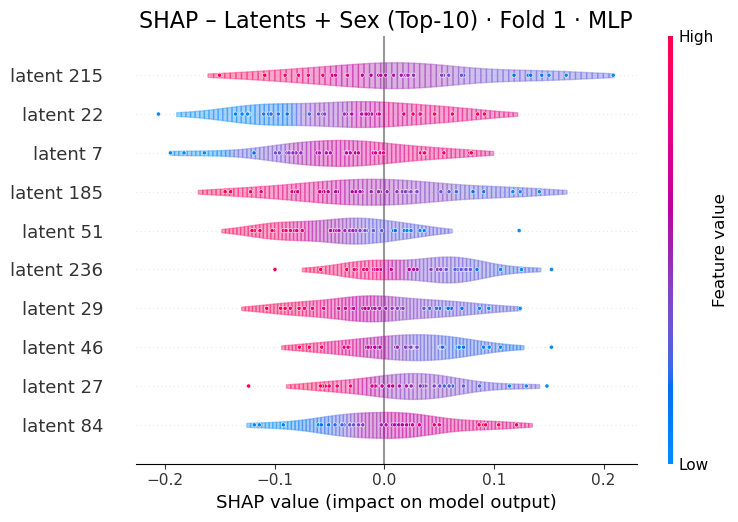

In [76]:
# === Importaciones y configuración inicial ===
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.collections
from tqdm.autonotebook import tqdm as notebook_tqdm
from pathlib import Path
import joblib, numpy as np, pandas as pd
import shap, re

# === Función de ayuda para ajustar la opacidad ===
def _ajustar_opacidad_violin(ax=None, alpha=0.35, subir_puntos=True):
    """
    Baja la opacidad de los violines creados por shap.summary_plot(plot_type='violin').
    alpha: 0 (transparente) ... 1 (opaco)
    subir_puntos: si hay puntos (beeswarm), los pone por encima con un borde.
    """
    ax = ax or plt.gca()
    # Ajusta la opacidad de los violines (PolyCollection)
    for pc in ax.findobj(mpl.collections.PolyCollection):
        pc.set_alpha(alpha)
    # Ajusta la opacidad de otros patches (por si acaso)
    for p in ax.patches:
        try: p.set_alpha(alpha)
        except Exception: pass
    if subir_puntos:
        # Pone los puntos del beeswarm (PathCollection) por delante
        for sc in ax.findobj(mpl.collections.PathCollection):
            sc.set_zorder(3)
            # Opcional: añade un borde blanco para que destaquen más
            sc.set_edgecolor("white")
            sc.set_linewidth(0.4)

# === Carga de datos ===
RUN_DIR = Path("./resultados_13_paper_qc_beta3")
FOLD    = 1
CLF     = "mlp"

# --- FIX: Cargar el pack 'fixed' (resultado del hotfix) o 'frozen' (el input) ---
pack_path_fixed = RUN_DIR / f"fold_{FOLD}/interpretability_shap/shap_pack_{CLF}_fixed.joblib"
pack_path_frozen = RUN_DIR / f"fold_{FOLD}/interpretability_shap/shap_pack_{CLF}_frozen.joblib"

if pack_path_fixed.exists():
    pack_path = pack_path_fixed
elif pack_path_frozen.exists():
    pack_path = pack_path_frozen
else:
    raise FileNotFoundError(f"No se encontró ni 'fixed' ni 'frozen' pack para el fold {FOLD} en {RUN_DIR}")

print(f"Cargando pack: {pack_path.name}")
pack = joblib.load(pack_path)
# --- FIN FIX ---
shap_vals = pack["shap_values"]            # (N,F) para clase positiva
Xtest     = pack["X_test"]                 # DataFrame post-preproc
featnames = list(map(str, pack["feature_names"]))

# Máscaras robustas para seleccionar features
latent_mask = np.array([re.search(r'(?:^|__)latent_\d+\b', c) is not None for c in featnames])
age_mask    = np.array([re.search(r'(?:^|__)Age\b', c) is not None for c in featnames])
# --- (AÑADIR esta línea junto a las máscaras) ---
sex_mask    = np.array([re.search(r'(?:^|__)Sex\b', c) is not None for c in featnames])


# === SHAP para Age (KDE-safe) ===
if age_mask.any():
    summary_plot_single_safe(
        shap_vals[:, age_mask], 
        Xtest.loc[:, age_mask], 
        "Age",
        f"SHAP – Age · Fold {FOLD} · {CLF.upper()}",
        RUN_DIR / f"fold_{FOLD}/interpretability_shap/shap_age_combined.png",
        RUN_DIR / f"fold_{FOLD}/interpretability_shap/shap_age_combined.svg",
        RUN_DIR / f"fold_{FOLD}/interpretability_shap/shap_age_combined.pdf",
        prefer_violin=True,
        eps=EPS
    )
else:
    print("⚠️ 'Age' no está en X_test.")

# === (REEMPLAZAR POR COMPLETO "Gráficos para features latentes" ===
# ===   por este bloque que hace Latentes + Sex ordenado por importancia) ===
TOPK = 10  # ajustá el K a gusto (p.ej., 15/20)

# Conjunto de features: todas las latentes + Sex (Age queda fuera a propósito)
mask_latent_or_sex = latent_mask | sex_mask

if mask_latent_or_sex.any():
    X_sel   = Xtest.loc[:, mask_latent_or_sex]
    S_sel   = shap_vals[:, mask_latent_or_sex]
    names   = np.array(featnames)[mask_latent_or_sex]

    # Ranking global por mean(|SHAP|)
    mean_abs = np.mean(np.abs(S_sel), axis=0)
    order    = np.argsort(mean_abs)[::-1]
    top_idx  = order[:TOPK]

    # Subconjunto Top-K
    S_top = S_sel[:, top_idx]
    X_top = X_sel.iloc[:, top_idx]
    names_top = names[top_idx]

    # Nombres bonitos (latent_i -> "latent i"; Sex -> "Sex")
    pretty = []
    for n in names_top:
        if re.search(r'(?:^|__)Sex\b', n):
            pretty.append("Sex")
        else:
            m = re.search(r'latent_(\d+)', n)
            pretty.append(f"latent {m.group(1)}" if m else n)

    # Plot tipo violin (ordenado por SHAP); si Sex no está en el Top-K, no aparece
    plt.figure(figsize=(8, 4 + 0.3*len(top_idx)))
    shap.summary_plot(
        S_top,
        X_top,
        feature_names=pretty,
        plot_type="violin",
        show=False,
        max_display=len(top_idx)
    )
    _ajustar_opacidad_violin(alpha=0.35)

    plt.title(f"SHAP – Latents + Sex (Top-{len(top_idx)}) · Fold {FOLD} · {CLF.upper()}")
    plt.tight_layout()
    plt.savefig(RUN_DIR / f"fold_{FOLD}/interpretability_shap/shap_latents_plus_sex_top{len(top_idx)}_violin.png", dpi=150)
    plt.savefig(RUN_DIR / f"fold_{FOLD}/interpretability_shap/shap_latents_plus_sex_top{len(top_idx)}_violin.svg")
    plt.savefig(RUN_DIR / f"fold_{FOLD}/interpretability_shap/shap_latents_plus_sex_top{len(top_idx)}_violin.pdf")
    print(f"✅ Gráfico guardado: shap_latents_plus_sex_top{len(top_idx)}_violin.png/svg")
    plt.show()
    plt.close()
else:
    print("⚠️ No se detectaron columnas latentes ni Sex en X_test.")


In [77]:
import pandas as pd, pathlib as p

RUN_DIR = p.Path("./resultados_13_paper_qc_beta3")

for F in [1,2,3,4,5]:
    path = RUN_DIR / f"fold_{F}/interpretability_shap/fold{F}_shap_feature_importance_ranking.csv"
    print(f"\n=== Fold {F} · Top-15 (latentes + metadatos) ===")
    df = pd.read_csv(path).head(15)
    display(df[["pretty_feature","feature","mean_abs_shap"]])

print("\n=== Promedio entre folds · Top-20 ===")
display(pd.read_csv(RUN_DIR/"shap_feature_importance_across_folds.csv")
        .sort_values("mean_abs_shap_across_folds", ascending=False)
        .head(20))



=== Fold 1 · Top-15 (latentes + metadatos) ===


,pretty_feature,feature,mean_abs_shap
0,latent 215,latent_215,0.065634
1,latent 22,latent_22,0.065128
2,latent 7,latent_7,0.060700
3,latent 185,latent_185,0.059357
4,latent 51,latent_51,0.051714
5,latent 236,latent_236,0.050425
6,latent 29,latent_29,0.045807
7,latent 46,latent_46,0.045243
8,latent 27,latent_27,0.045054
9,latent 84,latent_84,0.044656



=== Fold 2 · Top-15 (latentes + metadatos) ===


,pretty_feature,feature,mean_abs_shap
0,latent 49,latent_49,0.134015
1,latent 105,latent_105,0.112290
2,latent 161,latent_161,0.097687
3,latent 75,latent_75,0.085308
4,latent 134,latent_134,0.085195
5,latent 200,latent_200,0.085097
6,latent 45,latent_45,0.084494
7,latent 18,latent_18,0.084259
8,latent 215,latent_215,0.083860
9,latent 7,latent_7,0.082967



=== Fold 3 · Top-15 (latentes + metadatos) ===


,pretty_feature,feature,mean_abs_shap
0,latent 216,latent_216,0.105163
1,latent 105,latent_105,0.101985
2,latent 32,latent_32,0.096049
3,latent 114,latent_114,0.095617
4,latent 202,latent_202,0.092789
5,latent 77,latent_77,0.084696
6,latent 193,latent_193,0.084138
7,latent 5,latent_5,0.082235
8,latent 26,latent_26,0.081836
9,latent 182,latent_182,0.080525



=== Fold 4 · Top-15 (latentes + metadatos) ===


,pretty_feature,feature,mean_abs_shap
0,latent 179,latent_179,0.095996
1,latent 1,latent_1,0.088346
2,latent 200,latent_200,0.084393
3,latent 7,latent_7,0.081792
4,latent 121,latent_121,0.076945
5,latent 113,latent_113,0.073096
6,latent 244,latent_244,0.072507
7,latent 22,latent_22,0.068026
8,latent 8,latent_8,0.066550
9,latent 232,latent_232,0.065063



=== Fold 5 · Top-15 (latentes + metadatos) ===


,pretty_feature,feature,mean_abs_shap
0,latent 231,latent_231,0.025417
1,latent 246,latent_246,0.025311
2,latent 237,latent_237,0.017607
3,latent 81,latent_81,0.017535
4,latent 52,latent_52,0.017297
5,latent 200,latent_200,0.015943
6,latent 143,latent_143,0.015791
7,latent 18,latent_18,0.015281
8,latent 79,latent_79,0.015021
9,latent 181,latent_181,0.014864



=== Promedio entre folds · Top-20 ===


,feature,pretty_feature,mean_abs_shap_across_folds,std_abs_shap_across_folds,n_folds
0,latent_7,latent 7,0.058963,0.031534,5
1,latent_105,latent 105,0.055456,0.049927,5
2,latent_215,latent 215,0.053719,0.029932,5
3,latent_200,latent 200,0.053322,0.032408,5
4,latent_22,latent 22,0.052334,0.030993,5
5,latent_161,latent 161,0.051549,0.035882,5
6,latent_1,latent 1,0.045504,0.027982,5
7,latent_202,latent 202,0.045398,0.029292,5
8,latent_237,latent 237,0.045050,0.031590,5
9,latent_244,latent 244,0.044571,0.032343,5


In [78]:
# 1) ¿Age realmente es constante en X_test del pack?
X = pack["X_test"]
age_cols = [c for c in X.columns if c.endswith("Age") or c.endswith("__Age")]
print("std(Age) en X_test:", X[age_cols].std().to_string())

# 2) ¿Age es constante en el background procesado?
import joblib, numpy as np
fold_dir = Path(RUN_DIR)/f"fold_{FOLD}"
bg = joblib.load(fold_dir/"shap_background_proc_mlp_global_cn.joblib")
age_cols_bg = [c for c in bg.columns if c.endswith("Age") or c.endswith("__Age")]
print("std(Age) en BG:", bg[age_cols_bg].std().to_string())

# 3) Magnitud SHAP de Age (debería ser << a la de latentes top si Age quedó fijo)
S = pack["shap_values"]
feat = list(map(str, pack["feature_names"]))
i_age = [i for i,n in enumerate(feat) if n.endswith("Age") or n.endswith("__Age")]
print("mean(|SHAP|) Age:", np.abs(S[:, i_age]).mean())


std(Age) en X_test: Age    7.034607e-18
std(Age) en BG: Age    1.429137e-14
mean(|SHAP|) Age: 0.0


In [79]:
from pathlib import Path
import joblib, numpy as np, pandas as pd, re

RUN_DIR = Path("/home/diego/Escritorio/limpio/resultados_13_paper_qc_beta3")
CLF = "mlp"
FOLDS = [1,2,3,4,5]

def prettify(n):
    if re.search(r'(?:^|__)Age\b', n): return "Age"
    if re.search(r'(?:^|__)Sex\b', n): return "Sex"
    m = re.search(r'latent_(\d+)', n)
    return f"latent {m.group(1)}" if m else n

all_ranks=[]
for f in FOLDS:
    fold_dir = RUN_DIR/f"fold_{f}/interpretability_shap"
    # <<< IMPORTANTE: priorizar UNFROZEN aquí >>>
    for suf in ("_unfrozen", "_fixed", "_frozen", ""):
        p = fold_dir/f"shap_pack_{CLF}{suf}.joblib"
        if p.exists():
            pack = joblib.load(p); break
    S = np.asarray(pack["shap_values"], float)
    names = list(map(str, pack["feature_names"]))
    mean_abs = np.abs(S).mean(axis=0)
    df = (pd.DataFrame({"feature":names, "mean_abs_shap":mean_abs})
            .assign(pretty_feature=lambda d: d["feature"].map(prettify))
            .sort_values("mean_abs_shap", ascending=False)
            .assign(fold=f))
    df.to_csv(fold_dir/f"fold{f}_shap_feature_importance_ranking_UNFROZEN.csv", index=False)
    all_ranks.append(df)

df_all = pd.concat(all_ranks, ignore_index=True)
df_global = (df_all.groupby(["feature","pretty_feature"], as_index=False)
                 .agg(mean_abs_shap_across_folds=("mean_abs_shap","mean"),
                      std_abs_shap_across_folds=("mean_abs_shap","std"),
                      n_folds=("fold","nunique"))
                 .sort_values("mean_abs_shap_across_folds", ascending=False))

# guardo y muestro un resumen top-20
out = RUN_DIR/"shap_feature_importance_across_folds_UNFROZEN.csv"
df_global.to_csv(out, index=False)
print("Guardado:", out)
print(df_global.head(20))


Guardado: /home/diego/Escritorio/limpio/resultados_13_paper_qc_beta3/shap_feature_importance_across_folds_UNFROZEN.csv
        feature pretty_feature  mean_abs_shap_across_folds  \
0           Age            Age                    0.835815   
1           Sex            Sex                    0.075694   
225    latent_7       latent 7                    0.058475   
10   latent_105     latent 105                    0.054939   
132  latent_215     latent 215                    0.054404   
116  latent_200     latent 200                    0.052427   
137   latent_22      latent 22                    0.051837   
72   latent_161     latent 161                    0.051498   
118  latent_202     latent 202                    0.046081   
3      latent_1       latent 1                    0.045107   
156  latent_237     latent 237                    0.044653   
164  latent_244     latent 244                    0.044015   
202   latent_49      latent 49                    0.043012   
199   latent_

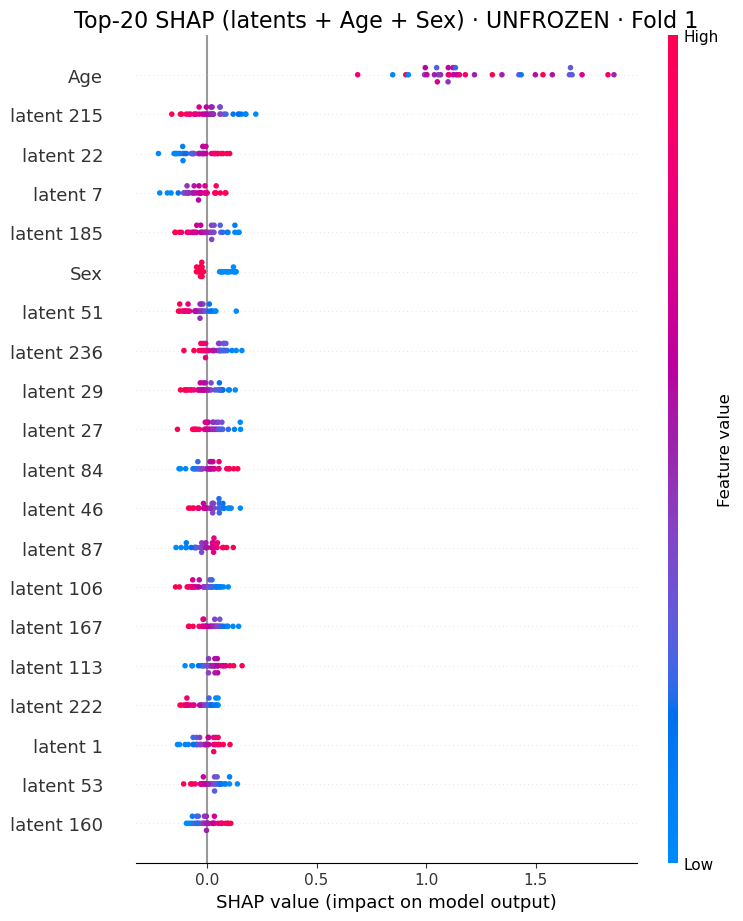

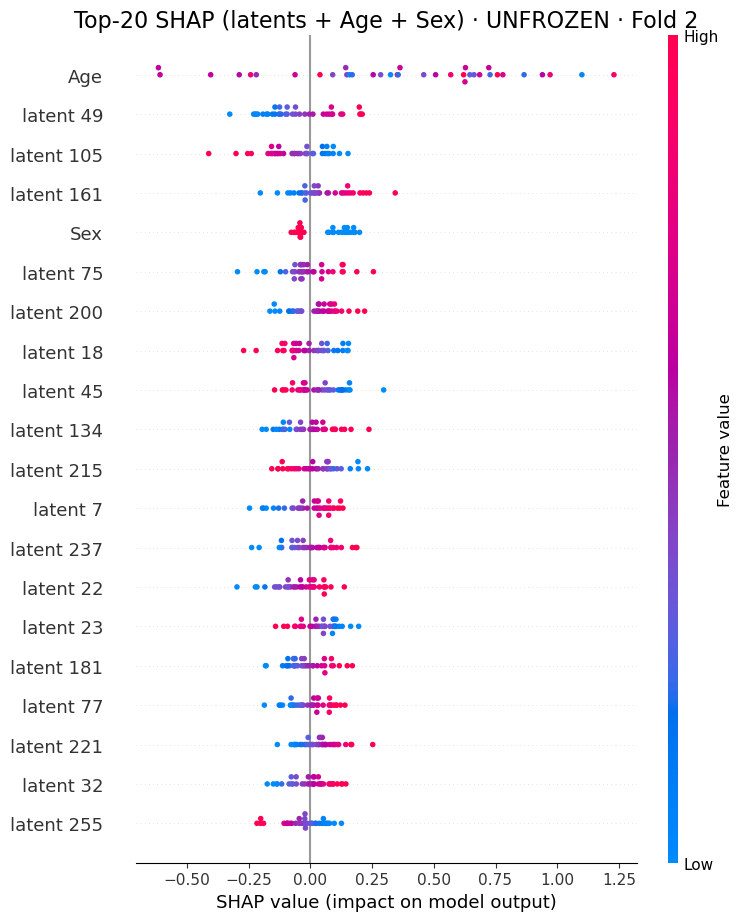

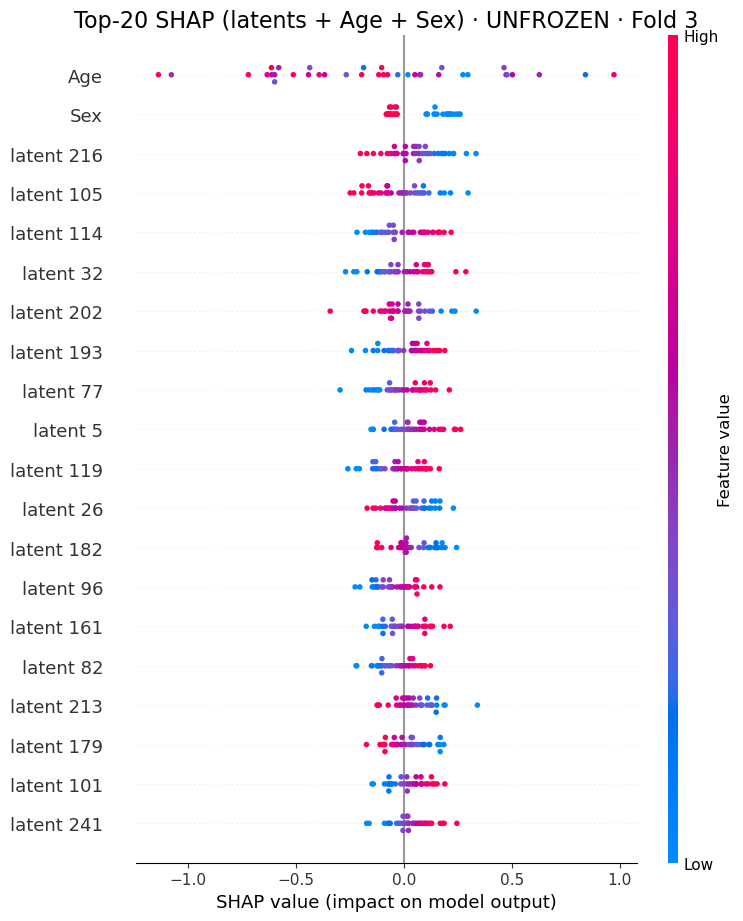

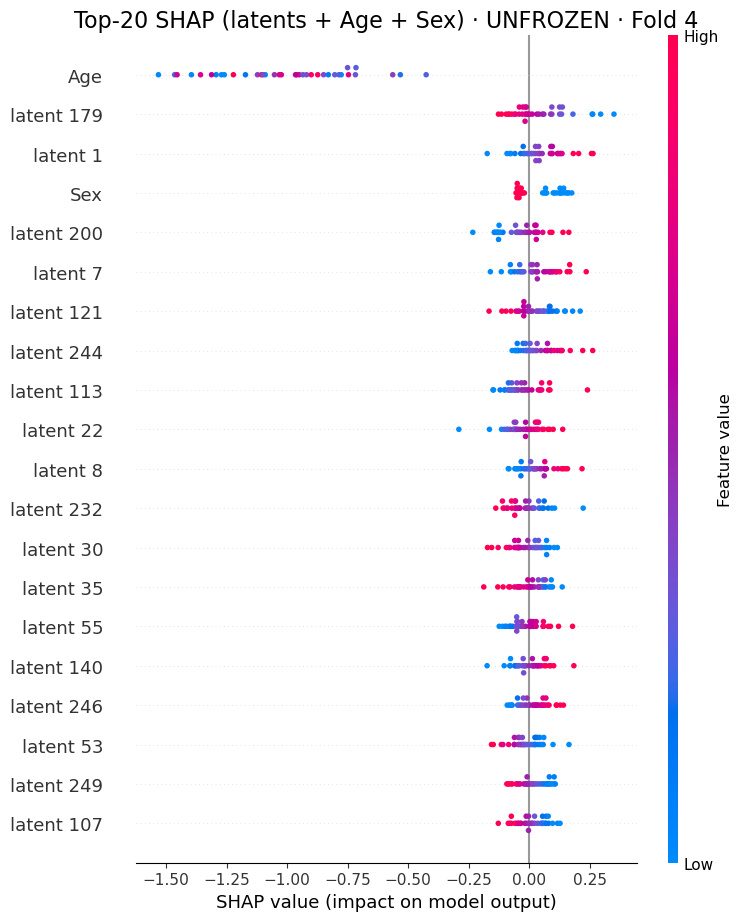

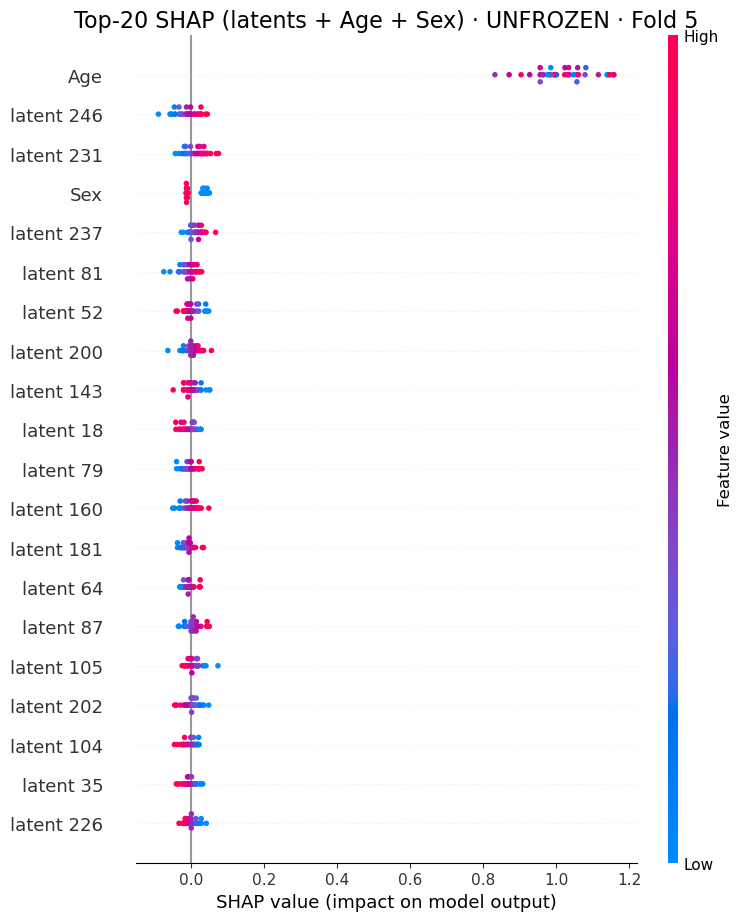

In [80]:
import shap, matplotlib.pyplot as plt, numpy as np

TOPK=20
for f in [1,2,3,4,5]:
    fold_dir = RUN_DIR/f"fold_{f}/interpretability_shap"
    # cargar UNFROZEN primero:
    for suf in ("_unfrozen", "_fixed", "_frozen", ""):
        p = fold_dir/f"shap_pack_{CLF}{suf}.joblib"
        if p.exists():
            pack = joblib.load(p); break
    S = np.asarray(pack["shap_values"], float)
    X = pack["X_test"]; names = list(map(str, pack["feature_names"]))
    mean_abs = np.abs(S).mean(axis=0)
    order = np.argsort(mean_abs)[::-1][:TOPK]
    plt.figure(figsize=(8,6))
    shap.summary_plot(S[:, order], X.iloc[:, order],
                      feature_names=[prettify(names[i]) for i in order],
                      show=False, max_display=TOPK)
    plt.title(f"Top-{TOPK} SHAP (latents + Age + Sex) · UNFROZEN · Fold {f}")
    plt.tight_layout()
    plt.savefig(fold_dir/f"fold{f}_shap_top{TOPK}_mixed_beeswarm_UNFROZEN.png", dpi=300)
    plt.show()
    plt.close()


Cargando pack: shap_pack_mlp_unfrozen.joblib
✅ Guardado: shap_age_unfrozen_combined.png, shap_age_unfrozen_combined.svg, shap_age_unfrozen_combined.pdf


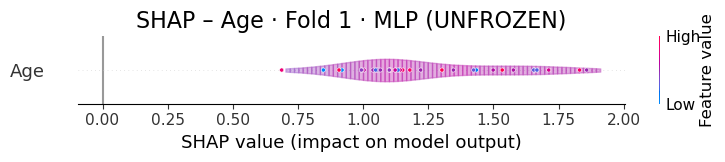

✅ Guardado: shap_latents_plus_sex_top3_unfrozen_violin.png, shap_latents_plus_sex_top3_unfrozen_violin.svg, shap_latents_plus_sex_top3_unfrozen_violin.pdf


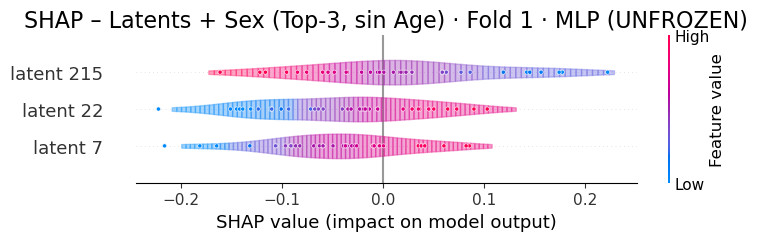

In [81]:
# === Importaciones y configuración inicial ===
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.collections
from tqdm.autonotebook import tqdm as notebook_tqdm
from pathlib import Path
import joblib, numpy as np, pandas as pd
import shap, re, os

# === Parámetros ===
RUN_DIR = Path("./resultados_13_paper_qc_beta3")
FOLD    = 1
CLF     = "mlp"
EPS     = 1e-6  # para jitter/estabilidad numérica leve

# === Helpers ===
def _ajustar_opacidad_violin(ax=None, alpha=0.35, subir_puntos=True):
    """
    Baja la opacidad de los violines (PolyCollection) y sube los puntos por delante,
    dejando borde blanco fino para destacar el beeswarm sobre el violín.
    """
    ax = ax or plt.gca()
    for pc in ax.findobj(mpl.collections.PolyCollection):
        pc.set_alpha(alpha)
    for p in ax.patches:
        try: p.set_alpha(alpha)
        except Exception: pass
    if subir_puntos:
        for sc in ax.findobj(mpl.collections.PathCollection):
            sc.set_zorder(3)
            sc.set_edgecolor("white")
            sc.set_linewidth(0.4)

def _save_multi(figpath_noext):
    """Guarda PNG/SVG/PDF con nombres coherentes a partir de una ruta sin extensión."""
    png = Path(str(figpath_noext) + ".png")
    svg = Path(str(figpath_noext) + ".svg")
    pdf = Path(str(figpath_noext) + ".pdf")
    plt.savefig(png, dpi=150)
    plt.savefig(svg)
    plt.savefig(pdf)
    print(f"✅ Guardado: {png.name}, {svg.name}, {pdf.name}")

def summary_plot_single_safe(shap_vals_1col, x_1col, featname, title, out_noext, prefer_violin=True):
    """
    Wrapper 'KDE-safe' para 1 sola característica (N,1).
    Si la varianza de X es ~0, agrega un jitter mínimo para evitar KDE degenerado.
    """
    s = np.asarray(shap_vals_1col)
    if s.ndim == 1: s = s.reshape(-1, 1)
    x = np.asarray(x_1col).reshape(-1, 1)

    # Jitter mínimo si la varianza es casi nula (p.ej., Sex codificado 0/1 con un solo valor)
    if np.nanstd(x) < EPS:
        x = x.astype(float) + np.random.default_rng(42).normal(0.0, EPS, size=x.shape)

    Xdf = pd.DataFrame({featname: x.ravel()})
    plt.figure(figsize=(7.4, 4.4))
    shap.summary_plot(
        s,
        Xdf,
        feature_names=[featname],
        plot_type="violin" if prefer_violin else "dot",
        show=False,
        max_display=1,
        sort=False,
        color_bar=True
    )
    _ajustar_opacidad_violin(alpha=0.35)
    plt.title(title)
    plt.tight_layout()
    _save_multi(out_noext)
    plt.show()
    plt.close()

# === Carga del pack UNFROZEN ===
pack_path_unfrozen = RUN_DIR / f"fold_{FOLD}/interpretability_shap/shap_pack_{CLF}_unfrozen.joblib"
if not pack_path_unfrozen.exists():
    raise FileNotFoundError(
        f"No se encontró el pack UNFROZEN en:\n  {pack_path_unfrozen}\n"
        "Generá primero ese pack (o revisá nombre/ruta)."
    )
print(f"Cargando pack: {pack_path_unfrozen.name}")
pack = joblib.load(pack_path_unfrozen)

# === Extrae matrices/tablas del pack ===
shap_vals = pack["shap_values"]      # (N,F) SHAP para la clase positiva
Xtest     = pack["X_test"]           # DataFrame post-preproc
featnames = list(map(str, pack["feature_names"]))

# === Máscaras robustas para seleccionar features ===
latent_mask = np.array([re.search(r'(?:^|__)latent_\d+\b', c) is not None for c in featnames])
age_mask    = np.array([re.search(r'(?:^|__)Age\b',    c) is not None for c in featnames])
sex_mask    = np.array([re.search(r'(?:^|__)Sex\b',    c) is not None for c in featnames])

# === Carpeta de salida separada para UNFROZEN ===
OUT_DIR = RUN_DIR / f"fold_{FOLD}/interpretability_shap_unfrozen"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# -------------------------------
# (A) SHAP – Age solamente
# -------------------------------
if age_mask.any():
    summary_plot_single_safe(
        shap_vals[:, age_mask],
        Xtest.loc[:, age_mask],
        "Age",
        f"SHAP – Age · Fold {FOLD} · {CLF.upper()} (UNFROZEN)",
        OUT_DIR / "shap_age_unfrozen_combined",
        prefer_violin=True
    )
else:
    print("⚠️ 'Age' no está en X_test.")

# ---------------------------------------------
# (B) SHAP – Top-5 (Latentes + Sex), sin Age
# ---------------------------------------------
TOPK = 3

# Conjunto de features: todas las latentes + Sex (Age fuera a propósito)
mask_latent_or_sex = (latent_mask | sex_mask) & (~age_mask)

if mask_latent_or_sex.any():
    X_sel   = Xtest.loc[:, mask_latent_or_sex]
    S_sel   = shap_vals[:, mask_latent_or_sex]
    names   = np.array(featnames)[mask_latent_or_sex]

    # Ranking global por mean(|SHAP|)
    mean_abs = np.mean(np.abs(S_sel), axis=0)
    order    = np.argsort(mean_abs)[::-1]
    k        = int(min(TOPK, S_sel.shape[1]))
    top_idx  = order[:k]

    S_top      = S_sel[:, top_idx]
    X_top      = X_sel.iloc[:, top_idx]
    names_top  = names[top_idx]

    # Nombres legibles: latent_i -> "latent i"; Sex -> "Sex"
    pretty = []
    for n in names_top:
        if re.search(r'(?:^|__)Sex\b', n):
            pretty.append("Sex")
        else:
            m = re.search(r'latent_(\d+)', n)
            pretty.append(f"latent {m.group(1)}" if m else n)

    plt.figure(figsize=(8.6, 4.8 + 0.35 * k))
    shap.summary_plot(
        S_top,
        X_top,
        feature_names=pretty,
        plot_type="violin",
        show=False,
        max_display=k,
        sort=True  # ya vienen top-K; True asegura de mayor a menor visualmente
    )
    _ajustar_opacidad_violin(alpha=0.35)

    plt.title(f"SHAP – Latents + Sex (Top-{k}, sin Age) · Fold {FOLD} · {CLF.upper()} (UNFROZEN)")
    plt.tight_layout()
    _save_multi(OUT_DIR / f"shap_latents_plus_sex_top{k}_unfrozen_violin")
    plt.show()
    plt.close()
else:
    print("⚠️ No se detectaron columnas latentes ni Sex (sin Age) en X_test.")
